In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Flatten, Masking
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from gensim.models import Word2Vec
import seaborn as sns
from tensorflow import keras
from keras.preprocessing import sequence

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
data = pd.read_csv('/content/data.csv')
data

,index,text,isfake
0,0,head conservative republican faction us congre...,0
1,1,transgender people allow first time enlist us ...,0
2,2,president donald trump call us postal service ...,0
3,3,west palm beach flathe white house say friday ...,0
4,4,west palm beach fla president donald trump say...,0
...,...,...,...
11754,11754,paul craig robertsin last years th century fra...,1
11755,11755,robert fantina counterpunchalthough unite stat...,1
11756,11756,st century wire say wire report earlier week u...,1
11757,11757,patrick henningsen st century wireremember oba...,1


In [4]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):

    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers

    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation

    tokenized_sentence = word_tokenize(sentence) ## tokenize
    stop_words = set(stopwords.words('english')) ## define stopwords

    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v")
        for word in tokenized_sentence_cleaned
    ]

    cleaned_sentence = ' '.join(word for word in lemmatized)

    return cleaned_sentence

In [5]:
%%time
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

data['text_clean'] = data['text'].apply(cleaning)
data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


CPU times: user 1min 1s, sys: 776 ms, total: 1min 2s
Wall time: 1min 6s


,index,text,isfake,text_clean
0,0,head conservative republican faction us congre...,0,head conservative republican faction us congre...
1,1,transgender people allow first time enlist us ...,0,transgender people allow first time enlist us ...
2,2,president donald trump call us postal service ...,0,president donald trump call us postal service ...
3,3,west palm beach flathe white house say friday ...,0,west palm beach flathe white house say friday ...
4,4,west palm beach fla president donald trump say...,0,west palm beach fla president donald trump say...
...,...,...,...,...
11754,11754,paul craig robertsin last years th century fra...,1,paul craig robertsin last years th century fra...
11755,11755,robert fantina counterpunchalthough unite stat...,1,robert fantina counterpunchalthough unite stat...
11756,11756,st century wire say wire report earlier week u...,1,st century wire say wire report earlier week u...
11757,11757,patrick henningsen st century wireremember oba...,1,patrick henningsen st century wireremember oba...


In [6]:
X = data.text_clean
y = data.isfake

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [8]:
X_train_split = [text_to_word_sequence(t) for t in X_train]
X_test_split = [text_to_word_sequence(t) for t in X_test]

In [9]:
len(X_train_split)

8231

In [10]:
w2v = Word2Vec(sentences = X_train_split, vector_size=100, window=5)
word = w2v.wv

In [11]:
word['make']

array([ 1.553393  , -0.4775955 ,  0.32542956, -0.49619126, -2.2297316 ,
       -1.935605  ,  0.4840245 , -1.467648  , -2.2533998 , -2.6079142 ,
       -0.37402394, -0.38767755,  0.77704793, -1.2609982 , -0.19016479,
        0.95162153,  1.8734328 , -0.15363872,  0.9030409 , -1.8844532 ,
       -1.368655  , -0.39725053,  2.1009126 , -0.9703979 , -1.4019742 ,
        0.7718052 ,  0.88115513,  0.5397305 , -0.6578522 ,  2.2882228 ,
       -0.36541158, -2.129278  ,  3.0451903 ,  0.6380663 ,  0.7133651 ,
        0.78313553, -0.5219726 ,  1.8930608 ,  1.8012006 , -0.3788173 ,
       -0.31114918, -0.81946063, -2.38608   ,  1.8944157 , -2.0918725 ,
       -1.8803785 ,  1.4093413 , -1.3087696 , -2.483228  , -1.166232  ,
       -0.94308925, -1.3926324 ,  0.9164056 ,  1.0425737 , -1.2919476 ,
       -2.2154238 , -1.428101  , -3.290831  ,  3.2702792 , -0.39442745,
       -3.5714605 , -0.35437468,  1.5467806 , -0.878549  , -1.2121983 ,
       -0.61030596, -0.865623  , -1.140772  , -1.4405067 ,  0.47

In [12]:
# Convert the text into a matrix of the words in the embedding space
def embed_sentence(w2v, text):
    embedded_text = []
    for words in text:
        if words in w2v.wv:
            embedded_text.append(w2v.wv[words])

    return np.array(embedded_text)

# Function that converts a list of sentences into a list of matrices
def embedding(w2v, texts):
    embed = []

    for text in texts:
        embedded_text = embed_sentence(w2v, text)
        embed.append(embedded_text)

    return embed

# Embed the training and test sentences
X_train_embed = embedding(w2v, X_train_split)
X_test_embed = embedding(w2v, X_test_split)

In [13]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed,truncating='post', maxlen=500)
X_test_pad = pad_sequences(X_test_embed, truncating='post', maxlen=500)

In [14]:
X_train_pad.shape

(8231, 500, 100)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

model_rnn = Sequential([
    Masking(mask_value=0, input_shape=(500,100)),
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics
model_rnn.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy'], metrics = ['accuracy'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=1000, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/1000
412/412 [==============================] - 66s 155ms/step - loss: 0.4951 - accuracy: 0.7457 - val_loss: 0.3702 - val_accuracy: 0.8403
Epoch 2/1000
412/412 [==============================] - 62s 150ms/step - loss: 0.3561 - accuracy: 0.8527 - val_loss: 0.2932 - val_accuracy: 0.8883
Epoch 3/1000
412/412 [==============================] - 63s 154ms/step - loss: 0.2886 - accuracy: 0.9019 - val_loss: 0.2382 - val_accuracy: 0.9144
Epoch 4/1000
412/412 [==============================] - 62s 151ms/step - loss: 0.2590 - accuracy: 0.9174 - val_loss: 0.2419 - val_accuracy: 0.9186
Epoch 5/1000
412/412 [==============================] - 63s 154ms/step - loss: 0.2279 - accuracy: 0.9294 - val_loss: 0.2529 - val_accuracy: 0.9156
Epoch 6/1000
412/412 [==============================] - 64s 154ms/step - loss: 0.2271 - accuracy: 0.9276 - val_loss: 0.2374 - val_accuracy: 0.9186
Epoch 7/1000
412/412 [==============================] - 62s 151ms/step - loss: 0.2095 - accuracy: 0.9358 - val_loss: 0

In [16]:
# Evaluate the model on the test set
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test)

111/111 [==============================] - 7s 58ms/step - loss: 0.2146 - accuracy: 0.9374


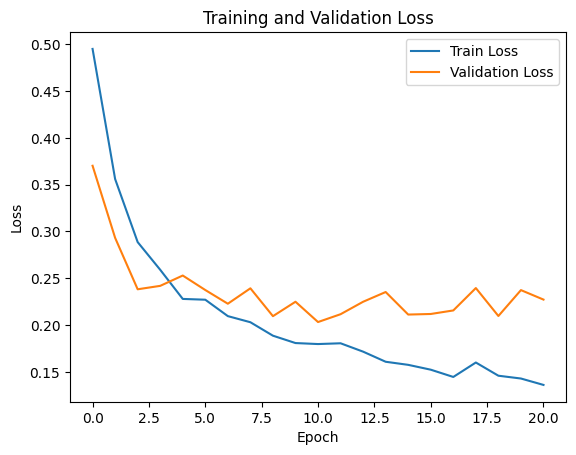

In [17]:
# Plot the training and validation loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

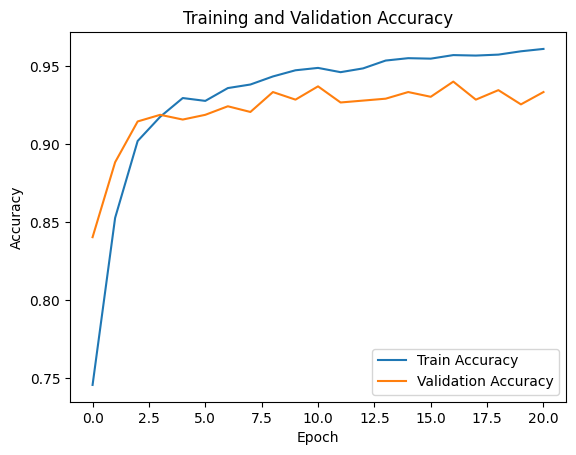

In [18]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

In [19]:
y_pred = model_rnn.predict(X_test_pad)

111/111 [==============================] - 5s 39ms/step


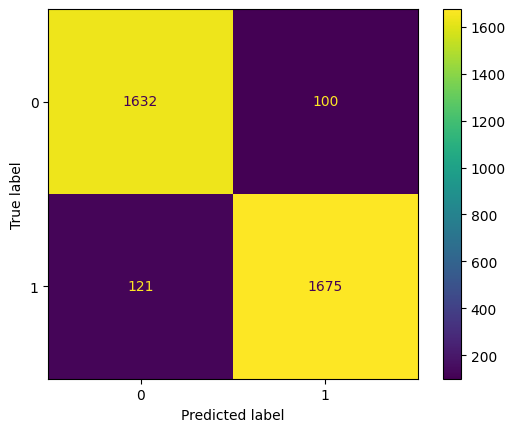

In [20]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf

predicted = tf.squeeze(y_pred)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

---

## New Texts on Both Models

In [21]:
bbc_snippet = """The UK faces another five years of high interest rates to stem rising prices, an influential global group has warned.
The International Monetary Fund expects the UK to have the highest inflation and slowest growth next year of any G7 economy including the US, France, Germany, Canada, Italy and Japan.
However, the Treasury said recent revisions to UK growth had not been factored in to the IMF's report.
The outlook was drawn up before this weekend's developments in Israel.
Forecasts are never perfect given the many factors that affect economic growth - from geopolitics to the weather. But such reports can point in the right direction, especially where they align with other forecasts.
The IMF, an international organisation with 190 member countries, has said the forecasts it makes for growth the following year in most advanced economies have, more often than not, been within about 1.5 percentage points of what actually happens.
In July last year, it forecast that the UK economy would grow by 3.2% in 2022. It revised that upwards to 4.1% at the start of this year.
But official UK figures released last month estimated that the country's economy actually expanded by 4.3% in 2022.
According to the IMF's latest forecast which it produces every six months, it expects the UK to grow more quickly than Germany in 2023, keeping the UK out of bottom place for growth among the G7.
But it downgraded the UK's prospects for growth next year, estimating the economy will grow by 0.6%, making it the slowest growing developed country in 2024 - widely predicted to be a general election year."""


In [22]:
theonion_snippet = """Claiming they had already made up their minds, area man Karl Wooley told reporters Tuesday
that he felt like the bystanders who were urging him to put his gun down were arguing in bad faith. “If I’m being
honest, it sort of feels like these onlookers are only thinking of themselves when they tell me to drop my pistol,” said Wooley, who observed that no one had even asked him to explain his reasoning for shouting at the top of his lungs and waving around a semiautomatic firearm. “Truth be told, they poisoned the well the second they tried to tackle me and forcibly rip the gun from my hands. But the worst part is how condescending they are—saying things like, ‘Hey, buddy, you don’t really want to do this.’ Maybe if they’d bothered to find out where I’m coming from and what my thoughts on the matter are, they’d know this is exactly what I want to be doing.” At press time, Wooley was reportedly shaking his head at how disrespectful his victims had become when they began resorting to ad hominem attacks like “You’re a monster” as he shot them to death."""

In [ ]:
# import spacy
# from spacy.lang.en import English
# from nltk.corpus import stopwords
# import nltk
# import time

# ## download the dictionary for stopwords
# nltk.download('stopwords')

# ## get the set of stopwords
# stop_words_set = set(stopwords.words('english'))

# ## Load English tokenizer from spacy
# nlp = English()
# spacy_tokenizer = nlp.tokenizer ## make instance

# ## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
# def optimized_preprocess(texts): ## Takes in a list of texts, i.e. the entire corpus
#     result = []

#     # Tokenize using spaCy's tokenizer
#     for text in texts:
#         tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
#         result.append(" ".join(tokens))

#     return result

[nltk_data] Downloading package stopwords to /Users/maria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
bbc_cleaned = cleaning(bbc_snippet)
theonion_cleaned = cleaning(theonion_snippet)

In [37]:
theonion_cleaned

'claim already make mind area man karl wooley tell reporters tuesday felt like bystanders urge put gun argue bad faith “ ’ honest sort feel like onlookers think tell drop pistol ” say wooley observe one even ask explain reason shout top lungs wave around semiautomatic firearm “ truth tell poison well second try tackle forcibly rip gun hand worst part condescend are—saying things like ‘ hey buddy ’ really want ’ maybe ’ bother find ’ come thoughts matter ’ know exactly want ” press time wooley reportedly shake head disrespectful victims become begin resort ad hominem attack like “ ’ monster ” shoot death'

In [ ]:
# bbc_cleaned = optimized_preprocess([bbc_snippet])
# theonion_cleaned = optimized_preprocess([theonion_snippet])


In [29]:
# bbc_split = [text_to_word_sequence(t) for t in bbc_cleaned]
# theonion_split = [text_to_word_sequence(t) for t in theonion_cleaned]

In [30]:
bbc_embed = embedding(w2v, bbc_cleaned)
theonion_embed = embedding(w2v, theonion_cleaned)

In [31]:
bbc_pad = pad_sequences(bbc_embed,truncating='post', maxlen=500)
theonion_pad = pad_sequences(theonion_embed,truncating='post', maxlen=500)

In [36]:
model_rnn.predict(bbc_pad).shape

33/33 [==============================] - 3s 83ms/step


(1026, 1)

In [32]:
print(model_rnn.predict(bbc_pad))
print(model_rnn.predict(theonion_pad))

33/33 [==============================] - 3s 78ms/step
[[0.31850624]
 [0.33928546]
 [0.31850624]
 ...
 [0.5586864 ]
 [0.31850624]
 [0.7201798 ]]
20/20 [==============================] - 1s 39ms/step
[[0.34304973]
 [0.4432066 ]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.4432066 ]
 [0.7201798 ]
 [0.5586864 ]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.33928546]
 [0.5586864 ]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.7201798 ]
 [0.5586864 ]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.33928546]
 [0.31850624]
 [0.7201798 ]
 [0.4432066 ]
 [0.31850624]
 [0.84334743]
 [0.31850624]
 [0.31850624]
 [0.4432066 ]
 [0.5586864 ]
 [0.31850624]
 [0.31850624]
 [0.31850624]
 [0.5586864 ]
 [0.4432066 ]
 [0.4432066 ]
 [0.31850624]
 [0.7201798 ]
 [0.5586864 ]
 [0.47994554]
 [0.31850624]
 [0.7201798 ]
 [0.31850624]
 [0.5586864 ]
 [0.

In [33]:
model_rnn.predict(bbc_pad)

33/33 [==============================] - 1s 40ms/step


array([[0.31850624],
       [0.33928546],
       [0.31850624],
       ...,
       [0.5586864 ],
       [0.31850624],
       [0.7201798 ]], dtype=float32)

In [34]:
model_rnn.predict(theonion_pad)

20/20 [==============================] - 1s 39ms/step


array([[0.34304973],
       [0.4432066 ],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.4432066 ],
       [0.7201798 ],
       [0.5586864 ],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.33928546],
       [0.5586864 ],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.7201798 ],
       [0.5586864 ],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.33928546],
       [0.31850624],
       [0.7201798 ],
       [0.4432066 ],
       [0.31850624],
       [0.84334743],
       [0.31850624],
       [0.31850624],
       [0.4432066 ],
       [0.5586864 ],
       [0.31850624],
       [0.31850624],
       [0.31850624],
       [0.5586864 ],
       [0.443

---

In [ ]:
model_rnn.save('modelRNN_sample.h5')